Contexte du projet:
La BPI France dispose d'un fond d'investissement qu'elle voudrait utiliser pour investir dans les start'up de demain les plus prometteuses. Seulement elle ne sait pas comment les sélectionner. Faut -il investir dans celles qui dépensent le plus en marketing ? en recherche et développement ? Dans quelles villes les startups semblent mieux opérer? Elle fait donc appel à vous pour y voir plus clair...

Vous devez donc concevoir un modèle de régression linéaire multiple qui permettra à la BPI d'une part de sélectionner les 5 start'up les plus prometteuses et d'autre part de déterminer dans quel(s) secteur(s) il serait le plus judicieux de répartir les budgets de dépenses.

En fournissant les budgets alloués aux différents pôles de travail, le modèle doit pouvoir prédire quel est le profit potentiel qui serait généré.

I.IMPORTATION des librairies

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scikitplot as skplt
from sklearn import metrics
import seaborn as sns
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text

Chargement du dataset

In [2]:
df = pd.read_csv('50_Startups.csv',sep=";")

II.DESCRIPTION du jeu de données

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   R&D             50 non-null     float64
 1   Administration  50 non-null     float64
 2   Marketing       50 non-null     float64
 3   villes          50 non-null     object 
 4   Profit          50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


Remarques: le jeu de données comporte peu d'entrées, donc peu de données sur lesquelles entraîner notre modèle. On peut déjà se poser la question de la précision du résultat.
Il faudra convertir le type object de la colonne ville pour le transformer en float. 

Les trois premières colonnes représentent les secteurs d'investissement.

La quatrième colonne les villes où se situent ces start-ups(peut-on discriminer par territoire?).

La cinquième colonne fera l'objet de notre label car on cherche à prédire le profit en fonction de l'argent alloué aux différents secteurs d'activité.
Il faut pouvoir saisir un montant dans chaque domaine ainsi que la ville pour obtenir un profit prédit.

III.EXPLORATION

In [4]:
#Informations descriptives relatives aux variables
df.head()

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,Paris,192261.83
1,162597.70,151377.59,443898.53,Strasbourg,191792.06
2,153441.51,101145.55,407934.54,Lyon,191050.39
3,144372.41,118671.85,383199.62,Paris,182901.99
4,142107.34,91391.77,366168.42,Lyon,166187.94


Remarque: les floats correspondent seulement à des entrées monétaires (on suppose en euros). Donc chaque ligne correspond à une start-up, à la répartition de ses investissements en fonction du secteur d'activité et à son profit.

In [5]:
len(pd.unique(df['villes']))

3

On compte seulement trois villes différentes dans le dataset. On pourrait inclure la ville comme target autant que le profit.

Je veux voir ma répartition par ville avant encodage, grâce à un histogramme.

Text(0, 0.5, 'Nombre de start-ups')

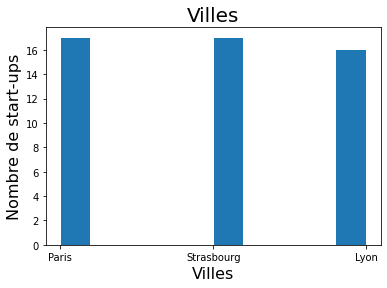

In [6]:
plt.hist(df['villes'],rwidth=0.95)
plt.title('Villes',fontsize = 20)
plt.xlabel('Villes',fontsize = 16)
plt.ylabel('Nombre de start-ups', fontsize = 16)

La répartition est quasi-équivalente.

In [7]:
##### Je veux voir si le profit moyen généré par ville diffère vraiment d'une ville à l'autre

df.groupby('villes')['Profit'].mean()

villes
Lyon          118774.024375
Paris         113756.446471
Strasbourg    103905.175294
Name: Profit, dtype: float64

Le profit moyen par ville est sensiblement le même pour les trois, si ce n'est une différence de 15000 euros environ entre Strasbourg et Lyon. Nous comparerons les résultats finaux entre un modèle qui prend en compte la variable de la ville et un autre qui ne la prend pas en compte.

<AxesSubplot:ylabel='None'>

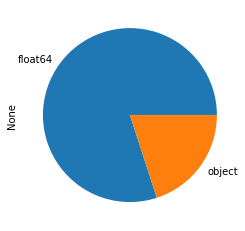

In [8]:
df.dtypes.value_counts().plot.pie()

Il y a peu d'object car concernent seulement les villes.

Faire une matrice de corrélation et heatmap

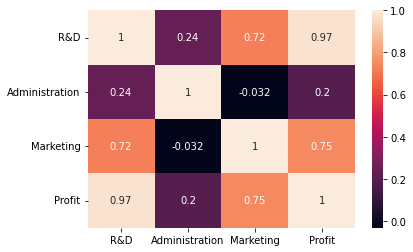

In [9]:
from seaborn import heatmap
correlation_mat = df.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

Il y a une forte corrélation positive entre le profit et les domaines des RetD et du Marketing.
On peut déjà dire qu'a priori le secteur de l'administration de rapporte pas le plus de profit.
Pour voir la corrélation entre profit et ville, il faut encoder les villes.

Encodage des villes

In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
label = preprocessing.LabelEncoder() 
 
df['villes']= label.fit_transform(df['villes']) 

Vérification

In [11]:
df.head(5)

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,1,192261.83
1,162597.70,151377.59,443898.53,2,191792.06
2,153441.51,101145.55,407934.54,0,191050.39
3,144372.41,118671.85,383199.62,1,182901.99
4,142107.34,91391.77,366168.42,0,166187.94


Je relance ma heatmap.

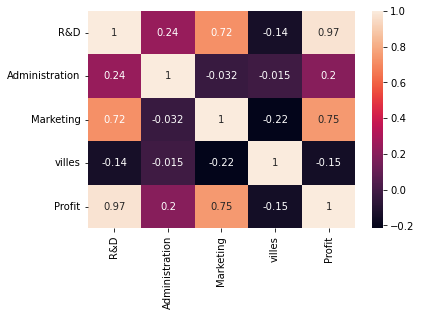

In [12]:
correlation_mat = df.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

On observe une corrélation négative intéressante entre les villes et le marketing mais pas de corrélation aussi grande qu'entre le profit et certains secteurs. Etant donné que les villes sont au départ des données catégorielles on ne peut pas tirer de conclusion de corrélation très représentative car cela ne nous indique pas l'influence de chaque ville.

IV.TRAITEMENT des données manquantes ou nulles

In [13]:
#manquantes
df.isna().sum()

R&D               0
Administration    0
Marketing         0
villes            0
Profit            0
dtype: int64

Je n'ai pas de données manquantes.

In [14]:
#nulles
df.isnull().sum()

R&D               0
Administration    0
Marketing         0
villes            0
Profit            0
dtype: int64

Je n'ai pas de valeurs nulles.

In [15]:
df.dtypes

R&D               float64
Administration    float64
Marketing         float64
villes              int32
Profit            float64
dtype: object

Je transforme ma colonne villes en float pour standardiser. 

In [16]:
df.villes = df.villes.astype('float64')

Vérification

In [17]:
df.head(5)

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,1.0,192261.83
1,162597.70,151377.59,443898.53,2.0,191792.06
2,153441.51,101145.55,407934.54,0.0,191050.39
3,144372.41,118671.85,383199.62,1.0,182901.99
4,142107.34,91391.77,366168.42,0.0,166187.94


V.VISUALISATION des données

Histogrammes

Text(0, 0.5, 'Nombre de start-ups')

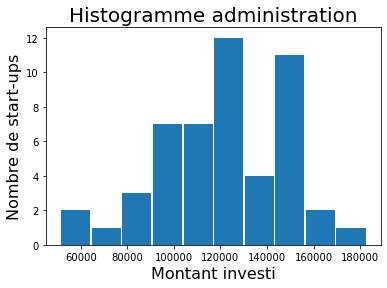

In [18]:
plt.hist(df['Administration'],rwidth=0.95)
plt.title('Histogramme administration',fontsize = 20)
plt.xlabel('Montant investi',fontsize = 16)
plt.ylabel('Nombre de start-ups', fontsize = 16)

Text(0, 0.5, 'Nombre de start-ups')

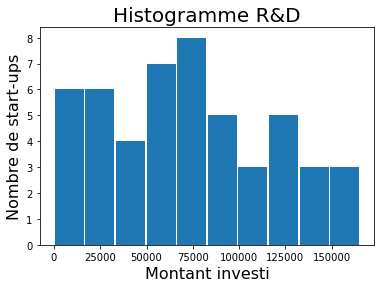

In [19]:
plt.hist(df['R&D'],rwidth=0.95)
plt.title('Histogramme R&D',fontsize = 20)
plt.xlabel('Montant investi',fontsize = 16)
plt.ylabel('Nombre de start-ups', fontsize = 16)

Text(0, 0.5, 'Nombre de start-ups')

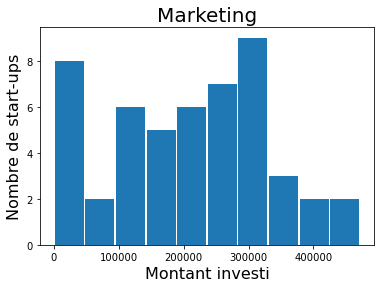

In [20]:
plt.hist(df['Marketing'],rwidth=0.95)
plt.title('Marketing',fontsize = 20)
plt.xlabel('Montant investi',fontsize = 16)
plt.ylabel('Nombre de start-ups', fontsize = 16)

Le secteur avec le plus d'investissements est celui du marketing.L'administratif vient en deuxième position et le R et D en troisième.

Text(0, 0.5, 'Nombre de start-ups')

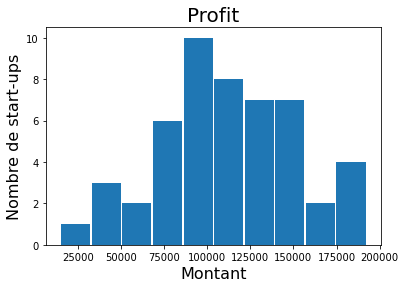

In [21]:
plt.hist(df['Profit'],rwidth=0.95)
plt.title('Profit',fontsize = 20)
plt.xlabel('Montant',fontsize = 16)
plt.ylabel('Nombre de start-ups', fontsize = 16)

Le profit de chaque start-up se situe entre 20000 et 190000 euros avec un pic de 90000 à 120000 euros.

Examen colonne target

In [22]:
df.Profit.value_counts()

192261.83    1
89949.14     1
105008.31    1
103282.38    1
101004.64    1
99937.59     1
97483.56     1
97427.84     1
96778.92     1
96712.80     1
96479.51     1
90708.19     1
81229.06     1
191792.06    1
81005.76     1
78239.91     1
77798.83     1
71498.49     1
69758.98     1
65200.33     1
64926.08     1
49490.75     1
42559.73     1
35673.41     1
105733.54    1
107404.34    1
108552.04    1
108733.99    1
191050.39    1
182901.99    1
166187.94    1
156991.12    1
156122.51    1
155752.60    1
152211.77    1
149759.96    1
146121.95    1
144259.40    1
141585.52    1
134307.35    1
132602.65    1
129917.04    1
126992.93    1
125370.37    1
124266.90    1
122776.86    1
118474.03    1
111313.02    1
110352.25    1
14681.40     1
Name: Profit, dtype: int64

La distribution de chaque colonne est à valeur unique.

VI Entraîner,tester,créer

In [23]:
#Définition des variables

y = df.iloc[:,-1]
X = df.iloc[:,:-1]

SPLIT le dataset en données de TRAINING et de TESTING.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [25]:
# vérifiez le nombre de données y dans chaque jeu (train et test)
y_test.value_counts()
y_train.value_counts()

155752.60    1
111313.02    1
141585.52    1
89949.14     1
108552.04    1
156122.51    1
108733.99    1
90708.19     1
122776.86    1
14681.40     1
149759.96    1
81005.76     1
49490.75     1
182901.99    1
192261.83    1
42559.73     1
191792.06    1
78239.91     1
132602.65    1
126992.93    1
64926.08     1
35673.41     1
101004.64    1
129917.04    1
99937.59     1
97427.84     1
71498.49     1
125370.37    1
118474.03    1
69758.98     1
152211.77    1
134307.35    1
107404.34    1
156991.12    1
65200.33     1
Name: Profit, dtype: int64

In [26]:
#vérification des dimensions
y_train.shape , y_test.shape

((35,), (15,))

CREATION du modèle

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lm = LinearRegression()

ENTRAINEMENT

In [28]:
lm.fit(X_train, y_train )

LinearRegression()

VII.PREDICTION

In [29]:
#Apply trained model to make prediction (on test set)

y_pred = lm.predict(X_test)
print(y_pred)

[104323.04953561 132562.98421652 133961.5334615   72621.26788067
 179972.6142242  114491.12697088  66393.34187512  98364.69880856
 114533.17016997 169420.72719794  96560.86804962  87993.43407499
 110996.72535647  90423.14367602 128061.34293359]


In [50]:
#Visualisation des coefficients

print('Coefficients:', lm.coef_)
print('Intercept:', lm.intercept_)


Coefficients: [ 7.91158296e-01  3.00676818e-02  3.09219732e-02 -2.43867367e+02]
Intercept: 42920.737440639394


In [31]:
print(df.columns)

Index(['R&D', 'Administration', 'Marketing', 'villes', 'Profit'], dtype='object')


Le coefficient RetD est plus conséquent que les autres.

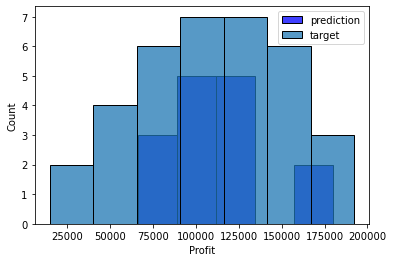

In [32]:
sns.histplot(y_pred, label='prediction',color='blue')
sns.histplot(y_train, label='target')
plt.legend()

In [33]:
#Je teste ma prédiction avec les données de la première ligne de mon dataset 

lm.predict([[165349.20,136897.80,471784.10,1.0]])

array([192198.95625419])

VIII.EVALUATION

Métriques d'évaluation

In [47]:
#R2 score
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score(y_test,y_pred)

0.9359239408935612

In [46]:
##MAE et RMSE mesurent des erreurs donc plus elles sont hautes plus il y a d'erreur.
#Ce sont des métriques intéressantes si on peut les comparer à d'autres modèles. Si on a beaucoup de variables il est plus facile
#d'utiliser la technique de backward evaluation pour tester les variables, plutôt que créer autant de modèles que de variables.

#MAE
mean_absolute_error(y_test, y_pred)


6521.175567625073

In [49]:
#RMSE
mean_squared_error(y_test, y_pred, squared=False)

7864.428856627148

Le résultat du r2_score est acceptable. Les résultats du MAE et RMSE doivent être comparés avec d'autres modèles.

Text(0.5, 1.0, 'Actual vs. Predicted')

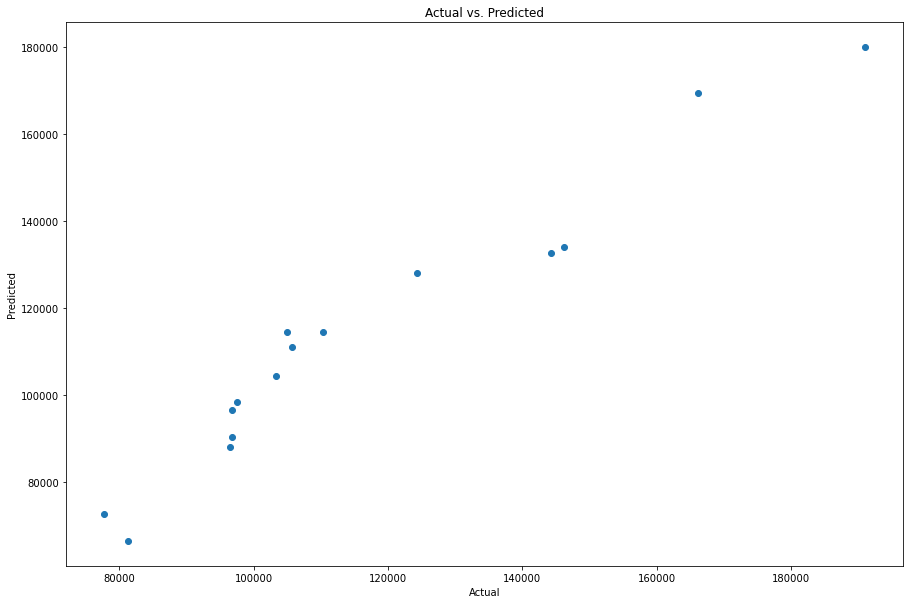

In [35]:
#Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

Le test de prédiction ainsi que la métrique R2 indiquent une prédiction satisfaisante pour notre modèle. La comparaison avec un autre modèle(celui de Fanny) qui ne comprend pas le secteur de l'administration et les villes montre que notre modèle est plus précis dans le résultat.